# Surf boards analyse


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Lasso
import lightgbm as lgb
import xgboost as xgb

## Getting Data

In [1]:
import gdown

# URL to the file on Google Drive
google_drive_url = 'https://drive.google.com/uc?id=1-1N4FUmCErD3iaHkzEWu3XSzOvLTBrfM'

# Path to save the file
output_path = '/content/df_surf.csv'

# Download and save the file
gdown.download(google_drive_url, output_path, quiet=False)

# Check if the file has been downloaded
import os
if os.path.exists(output_path):
    print(f"The file has been downloaded and saved as {output_path}")
else:
    print("Downloading the file failed.")


Downloading...
From: https://drive.google.com/uc?id=1-1N4FUmCErD3iaHkzEWu3XSzOvLTBrfM
To: /content/df_surf.csv
100%|██████████| 50.3k/50.3k [00:00<00:00, 33.8MB/s]

The file has been downloaded and saved as /content/df_surf.csv


In [3]:
# Load the data
df_surf = pd.read_csv('/content/df_surf.csv')

# Display the first few rows of the data
df_surf.head()

,board_adequate,board_how_many,board_length,board_nose_shape,board_tail_shape,board_thickness,board_type,board_volume,board_width,manoeuvres_01_paddling,...,surfer_gender,surfer_height,surfer_style,surfer_weight,wave_height,wave_shape,wave_height_min,wave_height_max,wave_height_mean,wave_height_interval
0,More or less,5.0,1.80,Pointed,"Outward (Round, Round-Pin, Pin)",2.31,Shortboard,26.7,18.31,Always,...,Male,1.72,Neutral,78.0,3.0,Spilling/Plunging,3.0,3.0,3.0,0.0
1,More or less,1.0,1.93,Pointed,"Neutral (Squash, Square)",NaN,All-around,NaN,NaN,Usually,...,Female,1.58,Smooth (recreative),54.0,2.0,Spilling,2.0,2.0,2.0,0.0
2,Very suitable,3.0,1.73,Pointed,"Neutral (Squash, Square)",2.56,Shortboard,30.5,20.38,Always,...,Male,1.73,Neutral,75.0,2.5,"Spilling, Spilling/Plunging, Plunging",2.0,5.0,3.5,3.0
3,Very suitable,1.0,1.80,Pointed,"Neutral (Squash, Square)",2.44,Shortboard,30.6,19.38,Always,...,Male,1.76,Neutral,76.0,3.6,"Spilling, Spilling/Plunging, Plunging",3.0,6.0,4.5,3.0
4,Suitable,5.0,1.78,Pointed,"Inward (Fish-tail, Swallow, Bat wing, Half moon)",NaN,All-around,NaN,NaN,Always,...,Male,1.77,Neutral,84.0,5.0,Spilling/Plunging,5.0,5.0,5.0,0.0


## Data Cleaning And Feature Engineering


In [4]:
# Basic statistics for the numeric columns
df_surf.describe()

,board_how_many,board_length,board_thickness,board_volume,board_width,performance_manoeuvrability,surfer_age,surfer_height,surfer_weight,wave_height,wave_height_min,wave_height_max,wave_height_mean,wave_height_interval
count,158.000000,156.000000,106.000000,101.000000,108.000000,162.000000,161.000000,163.000000,161.000000,163.000000,163.000000,163.000000,163.000000,163.000000
mean,3.234177,1.812308,2.469528,30.852970,19.434722,0.776173,34.571429,1.757301,75.152174,3.893865,3.748466,4.276074,4.012270,0.527607
std,4.850855,0.122379,0.244425,7.819819,0.983315,0.205693,7.927574,0.073283,10.538774,1.040696,1.101870,1.049917,0.971747,0.925048
min,1.000000,1.550000,2.000000,22.000000,18.000000,0.170000,16.000000,1.570000,36.000000,2.000000,2.000000,2.000000,2.000000,0.000000
25%,2.000000,1.750000,2.310000,27.000000,18.750000,0.670000,29.000000,1.710000,70.000000,3.000000,3.000000,4.000000,3.000000,0.000000
50%,2.000000,1.800000,2.380000,28.800000,19.250000,0.830000,33.000000,1.760000,75.000000,4.000000,4.000000,4.000000,4.000000,0.000000
75%,4.000000,1.850000,2.590000,32.300000,19.782500,1.000000,39.000000,1.800000,80.000000,5.000000,5.000000,5.000000,5.000000,1.000000
max,60.000000,2.440000,3.630000,83.500000,22.500000,1.000000,57.000000,1.940000,120.000000,6.000000,6.000000,6.000000,6.000000,4.000000


In [5]:
# Indo about data
df_surf.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   board_adequate                164 non-null    object 
 1   board_how_many                158 non-null    float64
 2   board_length                  156 non-null    float64
 3   board_nose_shape              164 non-null    object 
 4   board_tail_shape              164 non-null    object 
 5   board_thickness               106 non-null    float64
 6   board_type                    164 non-null    object 
 7   board_volume                  101 non-null    float64
 8   board_width                   108 non-null    float64
 9   manoeuvres_01_paddling        162 non-null    object 
 10  manoeuvres_02_drop            162 non-null    object 
 11  manoeuvres_03_straight_ahead  145 non-null    object 
 12  manoeuvres_04_wall_riding     161 non-null    object 
 13  manoe

In [6]:
# Analysis of missing values
missing_values = df_surf.isnull().sum()
missing_percentage = (df_surf.isnull().sum() / df_surf.shape[0]) * 100

# Creating a DataFrame with information on missing values
missing_data = pd.DataFrame({
    'Total missing values': missing_values,
    'Percentage of missing values': missing_percentage
})

# Sorting the DataFrame to show columns with the highest number of missing values
missing_data = missing_data.sort_values(by='Percentage of missing values', ascending=False)
print(missing_data.head(10))

                              Total missing values  \
board_volume                                    63   
board_thickness                                 58   
board_width                                     56   
manoeuvres_03_straight_ahead                    19   
manoeuvres_10_air                                9   
board_length                                     8   
board_how_many                                   6   
performance_hold                                 4   
surfer_weight                                    3   
manoeuvres_04_wall_riding                        3   

                              Percentage of missing values  
board_volume                                     38.414634  
board_thickness                                  35.365854  
board_width                                      34.146341  
manoeuvres_03_straight_ahead                     11.585366  
manoeuvres_10_air                                 5.487805  
board_length                           

In [7]:
# Replace missing values in numeric columns with the median
for column in df_surf.select_dtypes(include=['float64', 'int64']):
    df_surf[column].fillna(df_surf[column].median(), inplace=True)


In [8]:
# Replace missing values in categorical columns with the mode
for column in df_surf.select_dtypes(include=['object']):
    df_surf[column].fillna(df_surf[column].mode()[0], inplace=True)

In [9]:
# Apply label encoding to categorical columns
label_encoders = {}
for column in df_surf.select_dtypes(include=['object']):
    le = LabelEncoder()
    df_surf[column] = le.fit_transform(df_surf[column])
    label_encoders[column] = le


In [10]:
# Normalize the features using StandardScaler
scaler = StandardScaler()
df_processed = pd.DataFrame(scaler.fit_transform(df_surf), columns=df_surf.columns)

df_processed.head()

,board_adequate,board_how_many,board_length,board_nose_shape,board_tail_shape,board_thickness,board_type,board_volume,board_width,manoeuvres_01_paddling,...,surfer_gender,surfer_height,surfer_style,surfer_weight,wave_height,wave_shape,wave_height_min,wave_height_max,wave_height_mean,wave_height_interval
0,-1.063132,0.381109,-0.098378,-0.501231,1.064408,-0.638670,0.837122,-0.543742,-1.328593,-0.584765,...,0.254824,-0.512348,0.019594,0.273847,-0.864794,0.717419,-0.684740,-1.221012,-1.048033,-0.569799
1,-1.063132,-0.460667,0.994031,-0.501231,-0.268133,-0.289031,-1.384366,-0.204341,-0.152234,1.783173,...,-3.924283,-2.434490,1.090711,-2.031743,-1.831572,-1.150147,-1.597727,-2.179126,-2.083440,-0.569799
2,1.619232,-0.039779,-0.686599,-0.501231,-0.268133,0.610041,0.837122,0.070413,1.261900,-0.584765,...,0.254824,-0.375052,0.019594,-0.014351,-1.348183,0.094897,-1.597727,0.695217,-0.530330,2.689981
3,1.619232,-0.460667,-0.098378,-0.501231,-0.268133,0.010660,0.837122,0.086575,0.010454,-0.584765,...,0.254824,0.036835,0.019594,0.081715,-0.284728,0.094897,-0.684740,1.653332,0.505076,2.689981
4,-0.169011,0.381109,-0.266441,-0.501231,-1.600674,-0.289031,-1.384366,-0.204341,-0.152234,-0.584765,...,0.254824,0.174131,0.019594,0.850245,1.068761,0.717419,1.141234,0.695217,1.022779,-0.569799


## Surfing Performance Factors Visualisation


### Setting Features And Targets

In [11]:
df_processed.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   board_adequate                164 non-null    float64
 1   board_how_many                164 non-null    float64
 2   board_length                  164 non-null    float64
 3   board_nose_shape              164 non-null    float64
 4   board_tail_shape              164 non-null    float64
 5   board_thickness               164 non-null    float64
 6   board_type                    164 non-null    float64
 7   board_volume                  164 non-null    float64
 8   board_width                   164 non-null    float64
 9   manoeuvres_01_paddling        164 non-null    float64
 10  manoeuvres_02_drop            164 non-null    float64
 11  manoeuvres_03_straight_ahead  164 non-null    float64
 12  manoeuvres_04_wall_riding     164 non-null    float64
 13  manoe

In [12]:
# Extract feature and target columns from the dataframe
targets = ['performance_ease_paddling', 'performance_flotation', 'performance_hold',
          'performance_manoeuvrability', 'performance_passing_through',
          'performance_stability', 'performance_surf_speed', 'performance_control']


target = df_processed[targets]
features = df_processed.drop(target, axis=1)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

target.info(), features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   performance_ease_paddling    164 non-null    float64
 1   performance_flotation        164 non-null    float64
 2   performance_hold             164 non-null    float64
 3   performance_manoeuvrability  164 non-null    float64
 4   performance_passing_through  164 non-null    float64
 5   performance_stability        164 non-null    float64
 6   performance_surf_speed       164 non-null    float64
 7   performance_control          164 non-null    float64
dtypes: float64(8)
memory usage: 10.4 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   board_adequate                164 non-null    f

(None, None)

In [13]:
def plot_feature_importance(model_class, params, X, y, target_name, model_name):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    mae_scores = []
    feature_importance_dfs = []

    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        model = model_class(**params)
        model.fit(X_train_fold, y_train_fold)

        predictions = model.predict(X_test_fold)
        rmse_scores.append(mean_squared_error(y_test_fold, predictions, squared=False))
        mae_scores.append(mean_absolute_error(y_test_fold, predictions))

        feature_importance = model.feature_importances_ if hasattr(model, "feature_importances_") else model.coef_

        feature_importances = pd.DataFrame({
            'column': X.columns,
            'feature_importance': feature_importance
        })
        feature_importance_dfs.append(feature_importances)

    # Average feature importance
    df_feature_importance = pd.concat(feature_importance_dfs)
    order = df_feature_importance.groupby('column').sum().sort_values(by='feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=df_feature_importance, x='feature_importance', y='column', order=order, ax=ax, palette='viridis', orient='h')
    ax.tick_params(axis='x', rotation=0)
    ax.set_title(f'Feature Importances for {target_name} using {model_name}')
    ax.grid()
    fig.tight_layout()

    avg_rmse = np.mean(rmse_scores)
    avg_mae = np.mean(mae_scores)

    print(f"Average RMSE for {model_name} on {target_name}: {avg_rmse:.4f}")
    print(f"Average MAE for {model_name} on {target_name}: {avg_mae:.4f}")
    print("-" * 50)

    return avg_rmse, avg_mae


### Random Forest Model

Average RMSE for Random Forest on performance_ease_paddling: 0.9783
Average MAE for Random Forest on performance_ease_paddling: 0.8484
--------------------------------------------------
Average RMSE for Random Forest on performance_flotation: 1.0459
Average MAE for Random Forest on performance_flotation: 0.8795
--------------------------------------------------
Average RMSE for Random Forest on performance_hold: 0.9430
Average MAE for Random Forest on performance_hold: 0.8192
--------------------------------------------------
Average RMSE for Random Forest on performance_manoeuvrability: 0.7237
Average MAE for Random Forest on performance_manoeuvrability: 0.5435
--------------------------------------------------
Average RMSE for Random Forest on performance_passing_through: 1.0200
Average MAE for Random Forest on performance_passing_through: 0.8589
--------------------------------------------------
Average RMSE for Random Forest on performance_stability: 1.0698
Average MAE for Random F

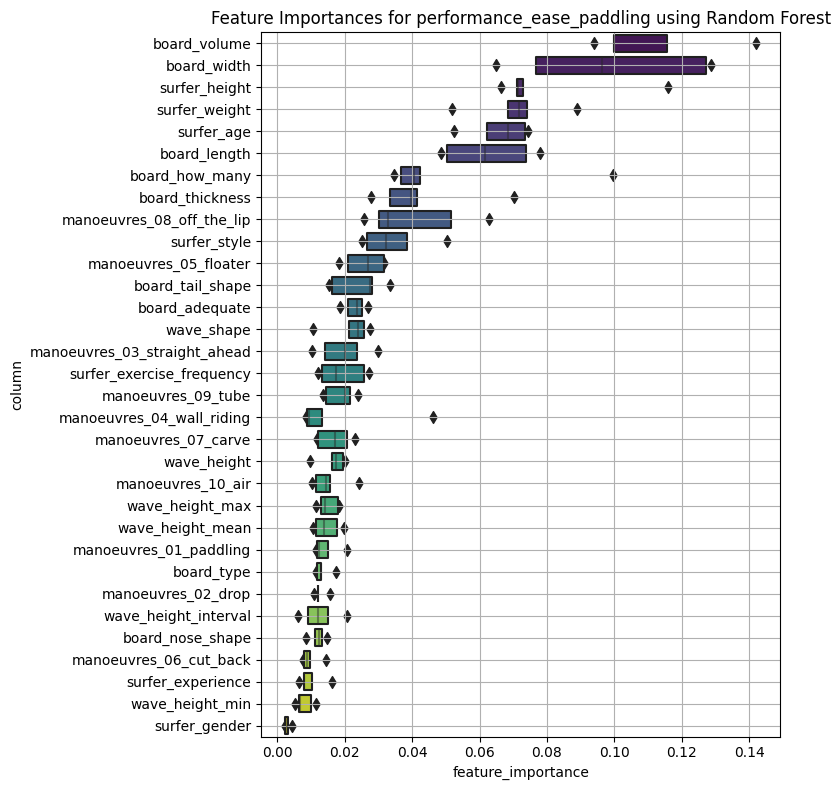

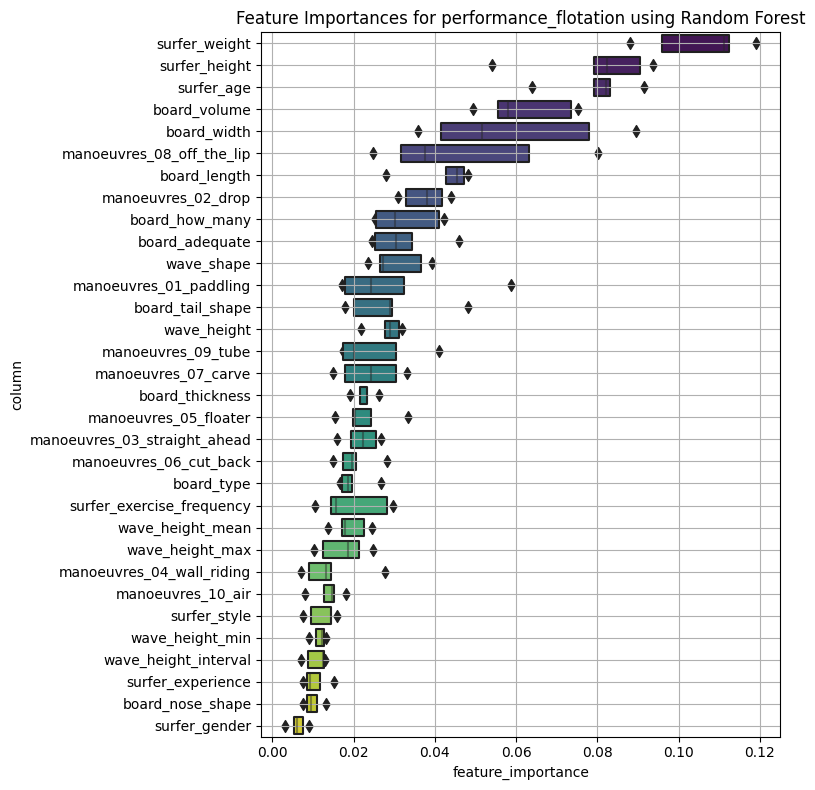

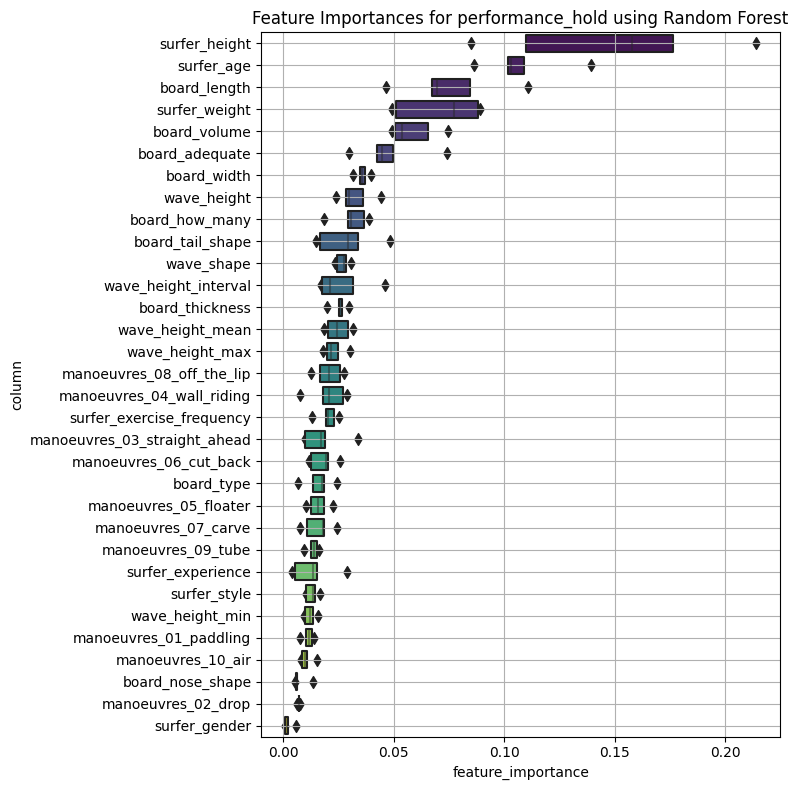

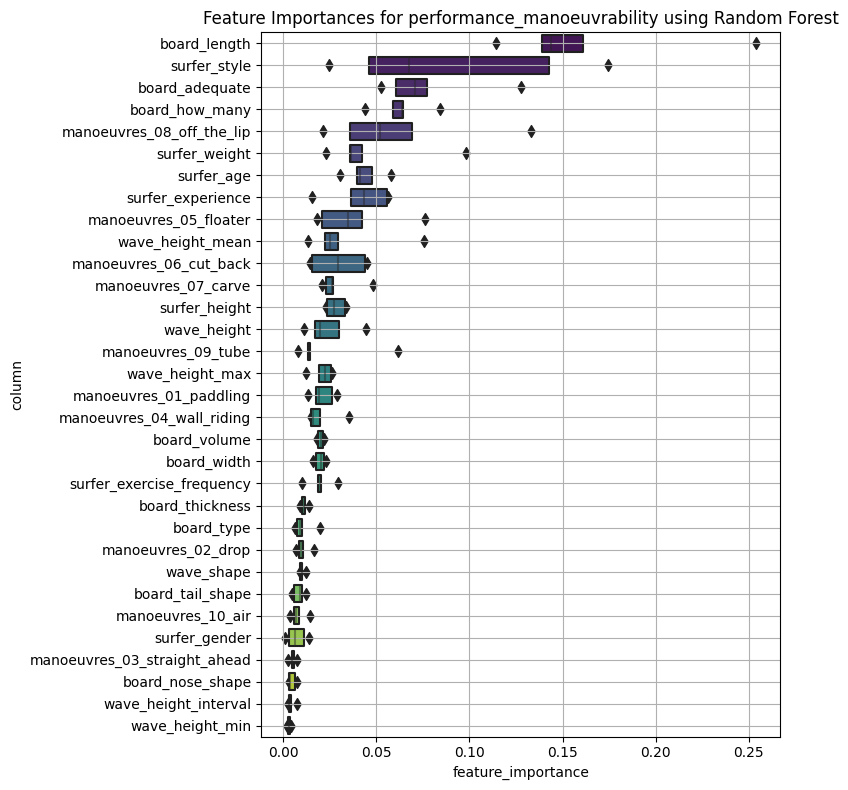

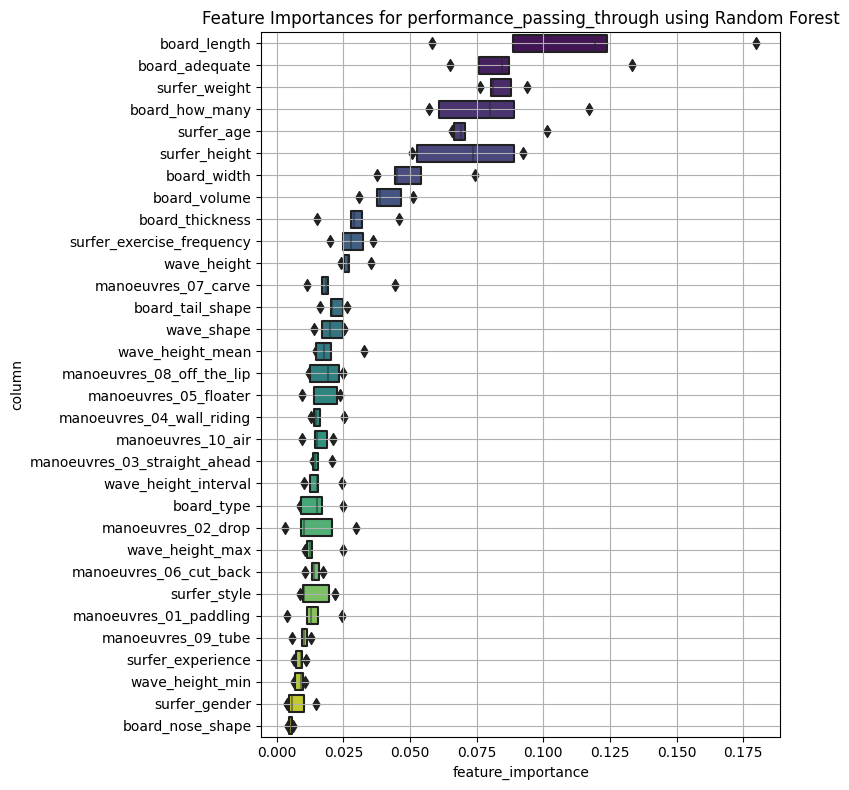

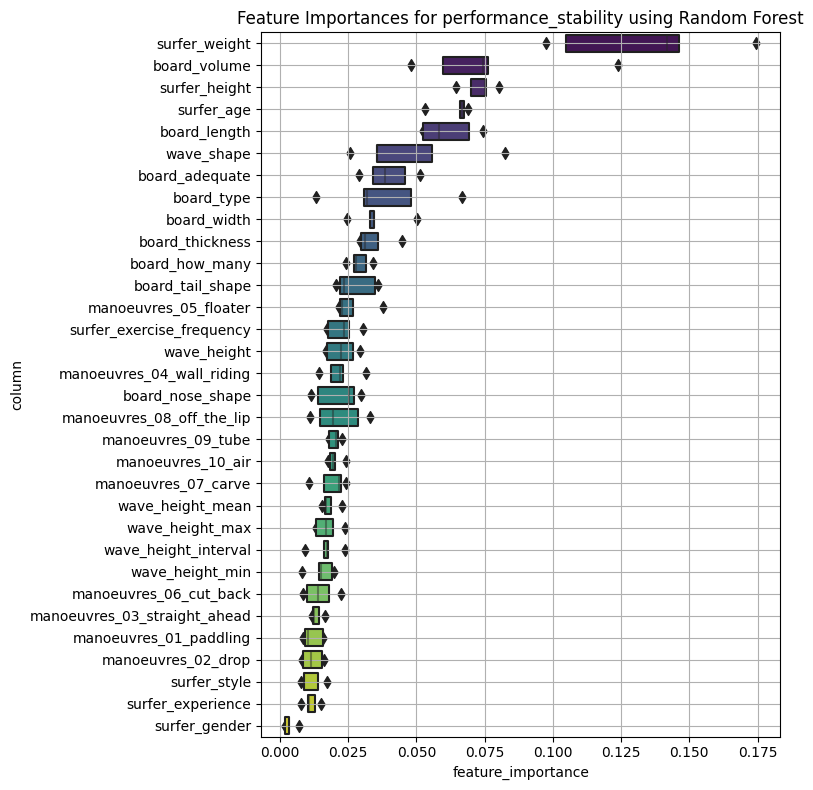

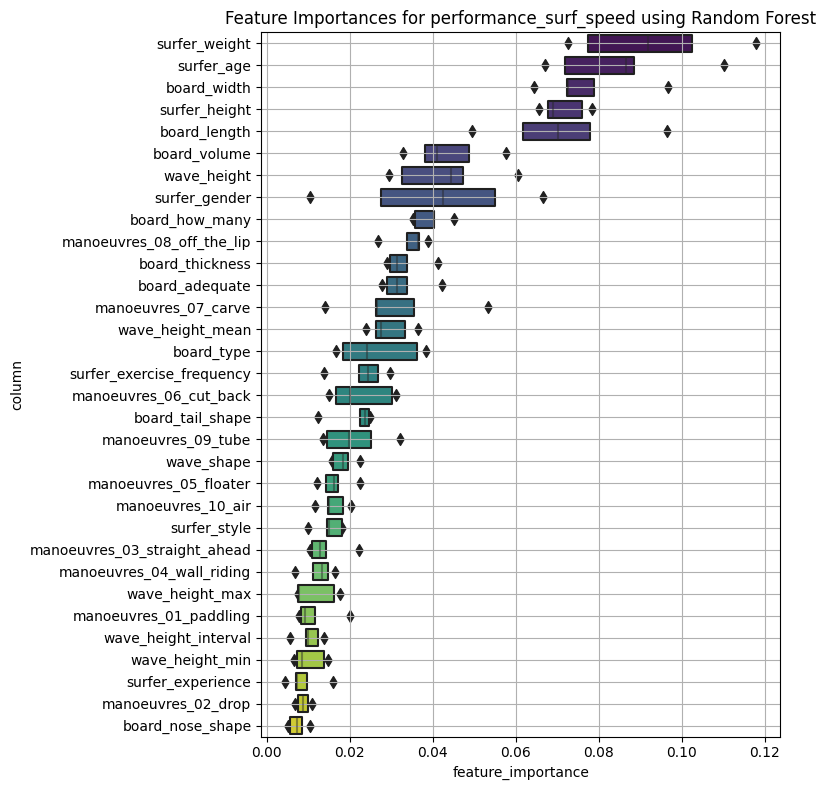

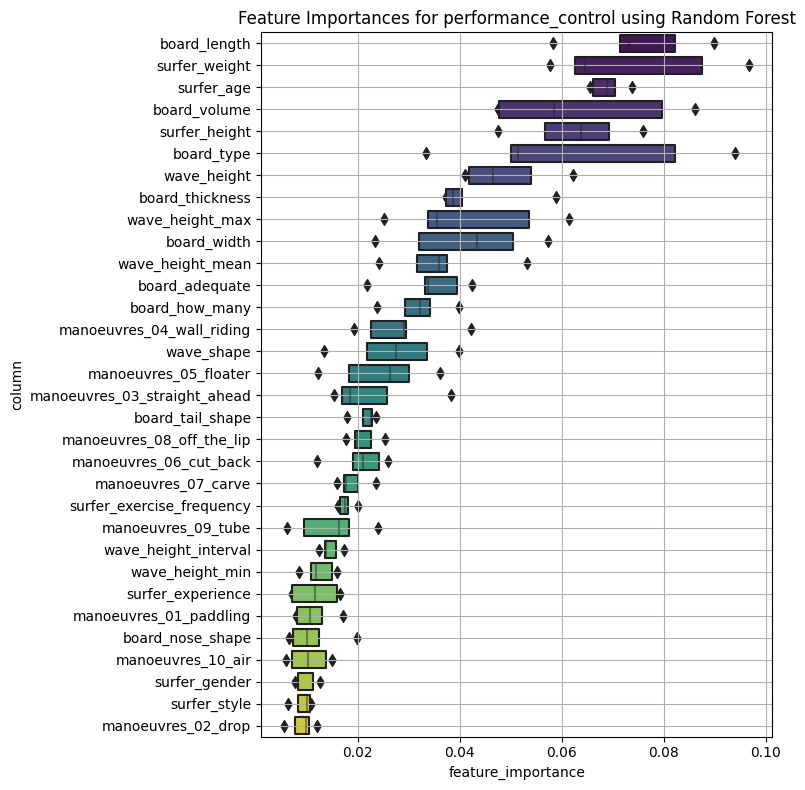

In [14]:
params_rf = {
    'n_estimators': 100,
    'random_state': 42
}

for target_column in targets:
    plot_feature_importance(RandomForestRegressor, params_rf, X_train, y_train[target_column], target_column, model_name='Random Forest')


### XGBoost Model

Average RMSE for XGBoost on performance_ease_paddling: 1.0215
Average MAE for XGBoost on performance_ease_paddling: 0.8153
--------------------------------------------------
Average RMSE for XGBoost on performance_flotation: 1.1808
Average MAE for XGBoost on performance_flotation: 0.9560
--------------------------------------------------
Average RMSE for XGBoost on performance_hold: 1.0076
Average MAE for XGBoost on performance_hold: 0.8276
--------------------------------------------------
Average RMSE for XGBoost on performance_manoeuvrability: 0.8183
Average MAE for XGBoost on performance_manoeuvrability: 0.6025
--------------------------------------------------
Average RMSE for XGBoost on performance_passing_through: 1.1268
Average MAE for XGBoost on performance_passing_through: 0.8986
--------------------------------------------------
Average RMSE for XGBoost on performance_stability: 1.1169
Average MAE for XGBoost on performance_stability: 0.9234
---------------------------------

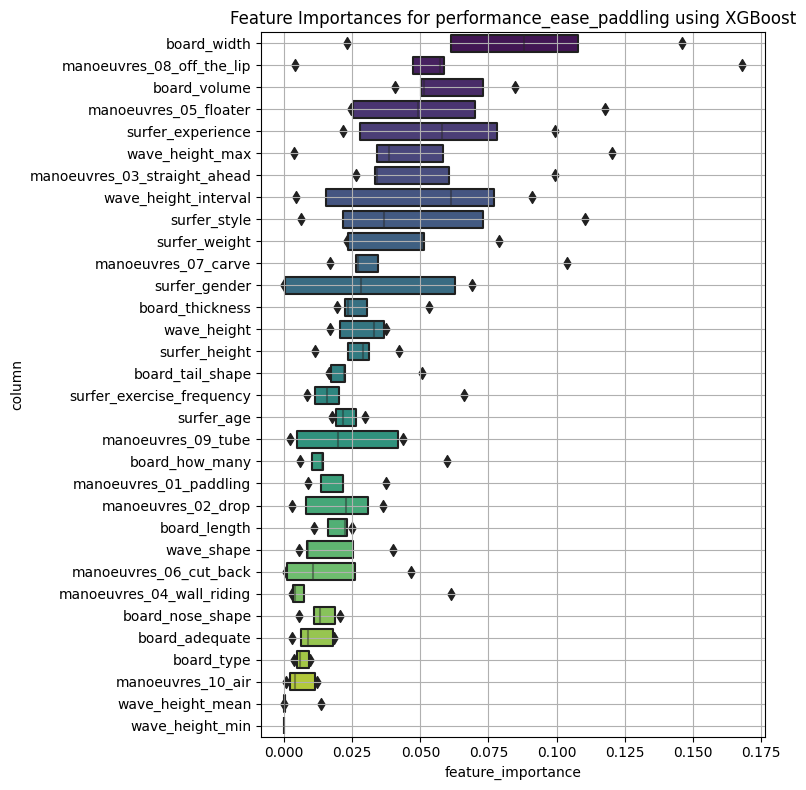

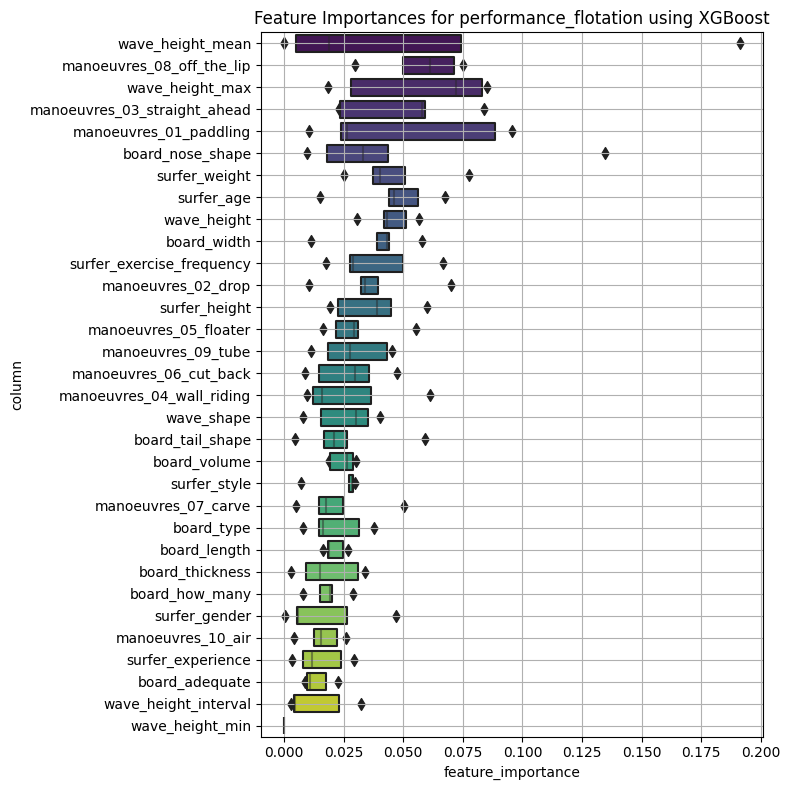

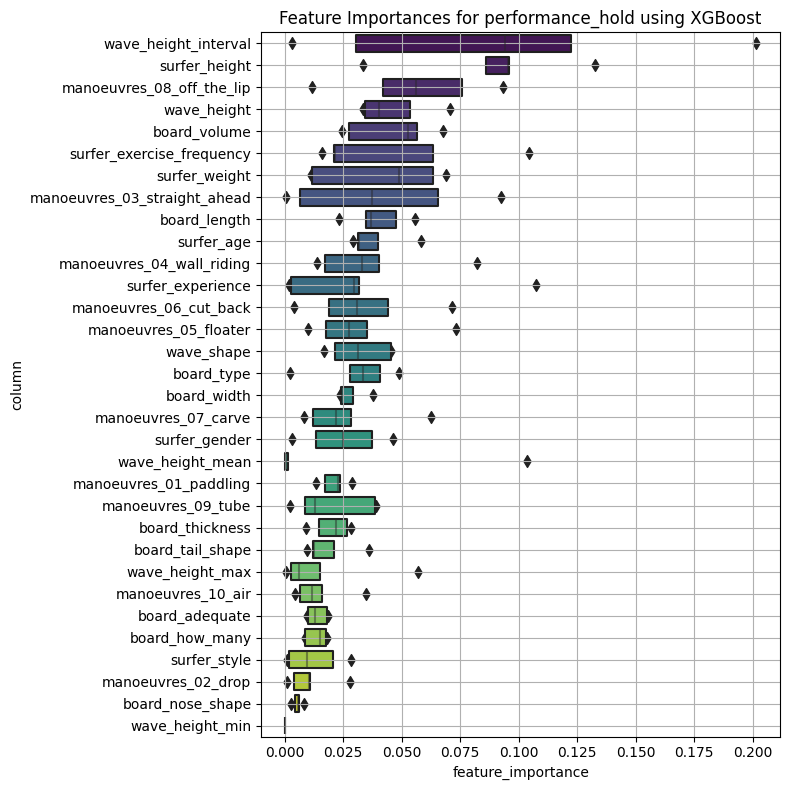

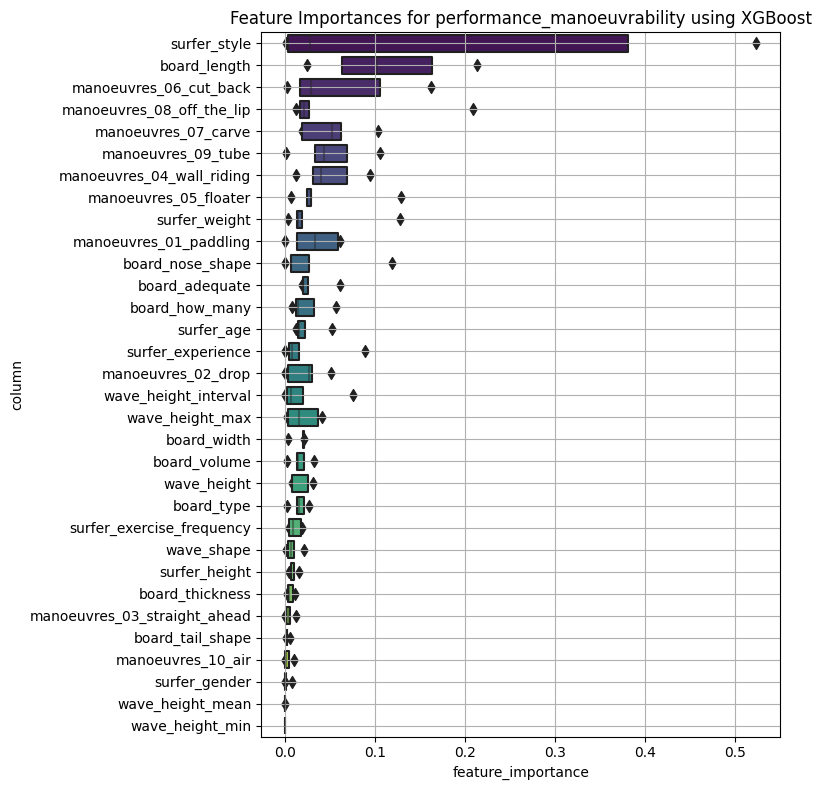

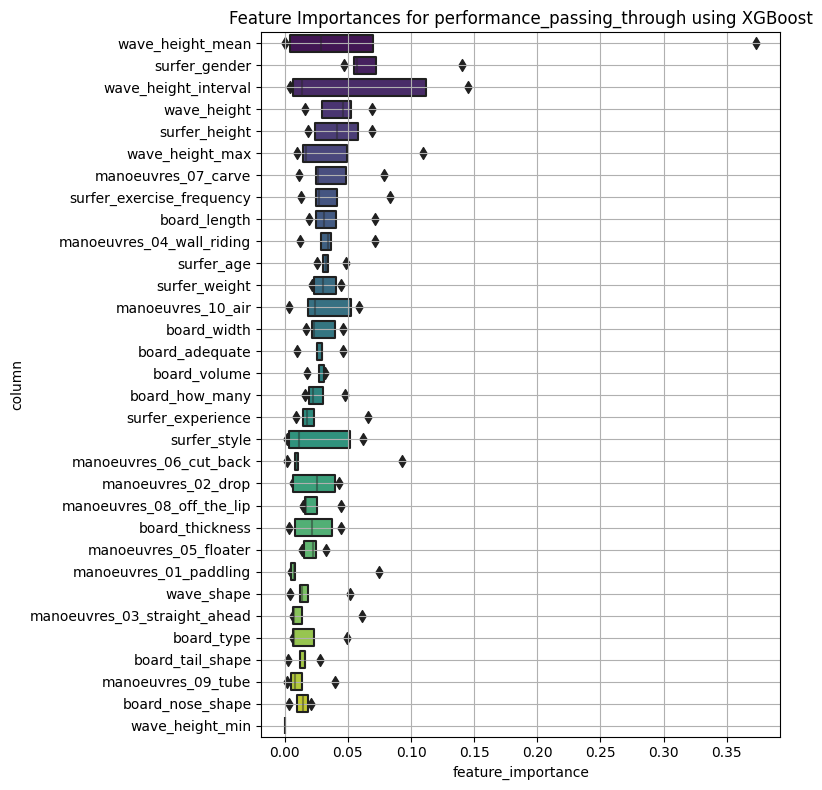

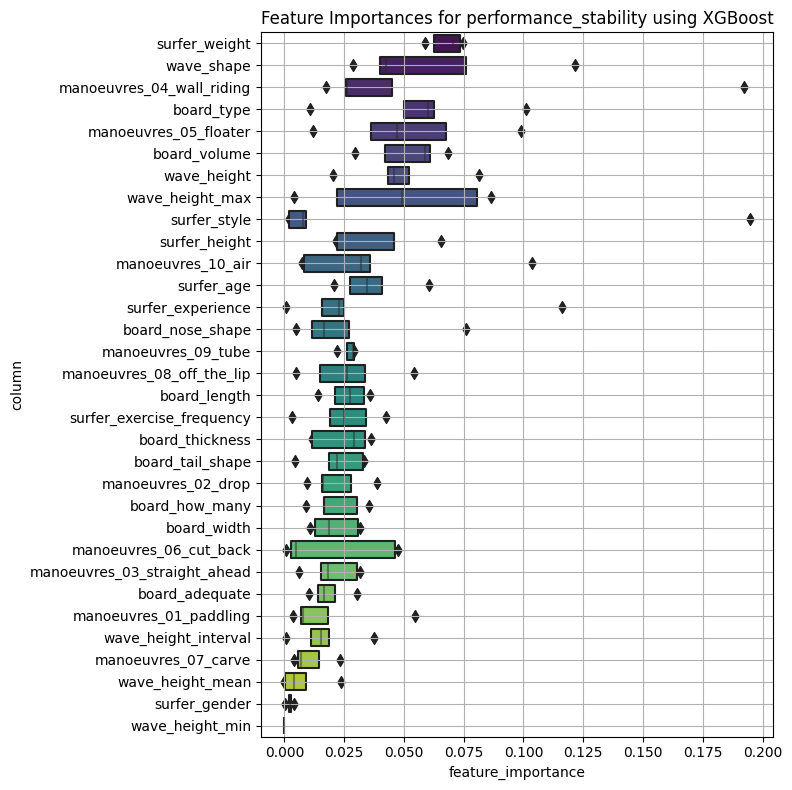

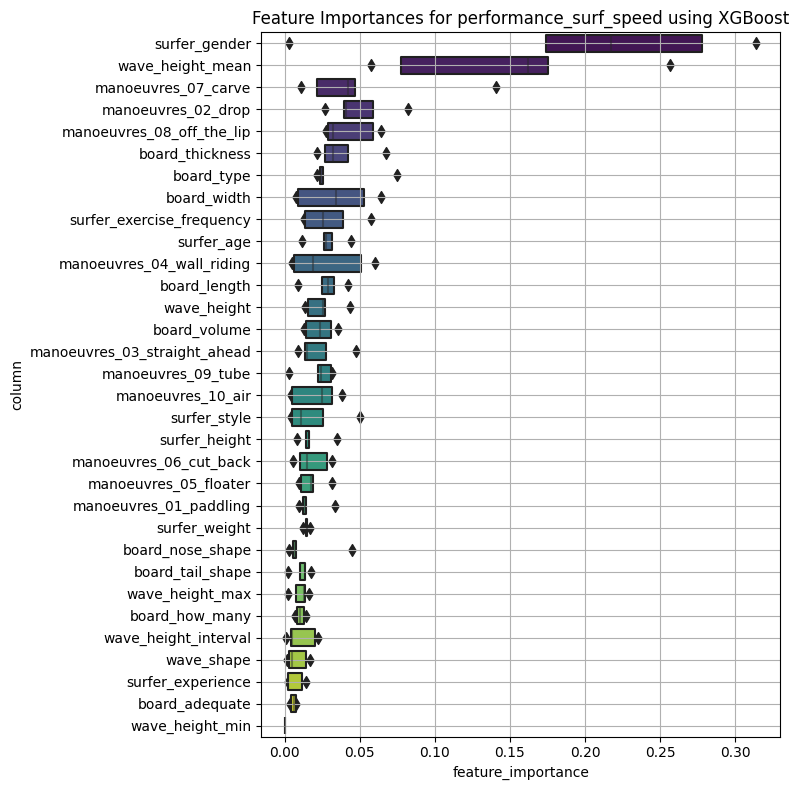

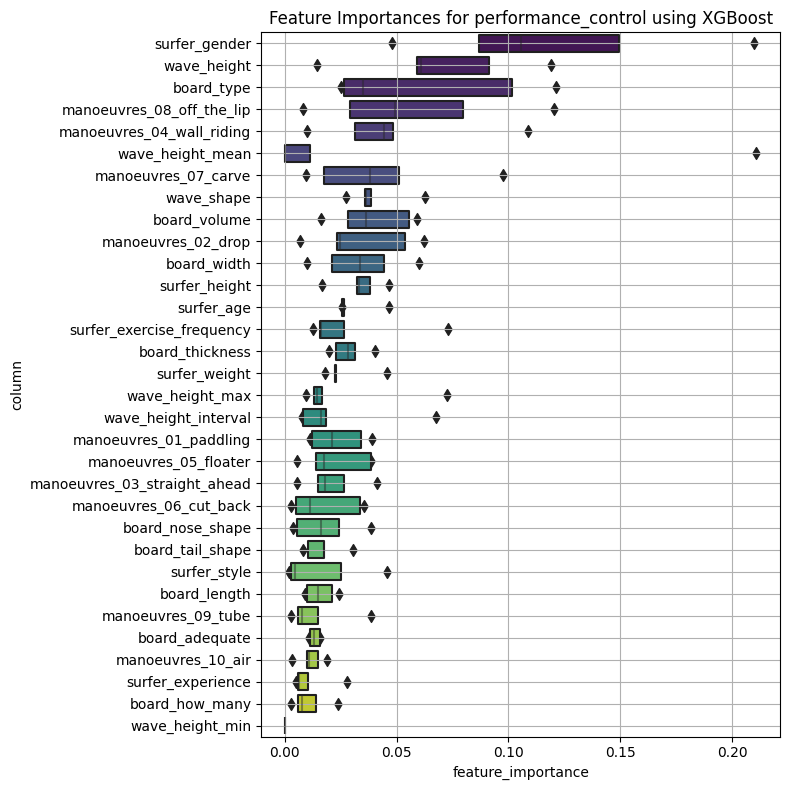

In [15]:
import xgboost as xgb

params_xgb = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'random_state': 42
}

for target_column in targets:
    plot_feature_importance(xgb.XGBRegressor, params_xgb, X_train, y_train[target_column], target_column, model_name='XGBoost')


### LightGBM Model

Average RMSE for LightGBM on performance_ease_paddling: 0.9842
Average MAE for LightGBM on performance_ease_paddling: 0.7947
--------------------------------------------------
Average RMSE for LightGBM on performance_flotation: 1.0728
Average MAE for LightGBM on performance_flotation: 0.9070
--------------------------------------------------
Average RMSE for LightGBM on performance_hold: 0.9195
Average MAE for LightGBM on performance_hold: 0.7647
--------------------------------------------------
Average RMSE for LightGBM on performance_manoeuvrability: 0.7589
Average MAE for LightGBM on performance_manoeuvrability: 0.5858
--------------------------------------------------
Average RMSE for LightGBM on performance_passing_through: 1.0572
Average MAE for LightGBM on performance_passing_through: 0.8840
--------------------------------------------------
Average RMSE for LightGBM on performance_stability: 1.1416
Average MAE for LightGBM on performance_stability: 0.9573
---------------------

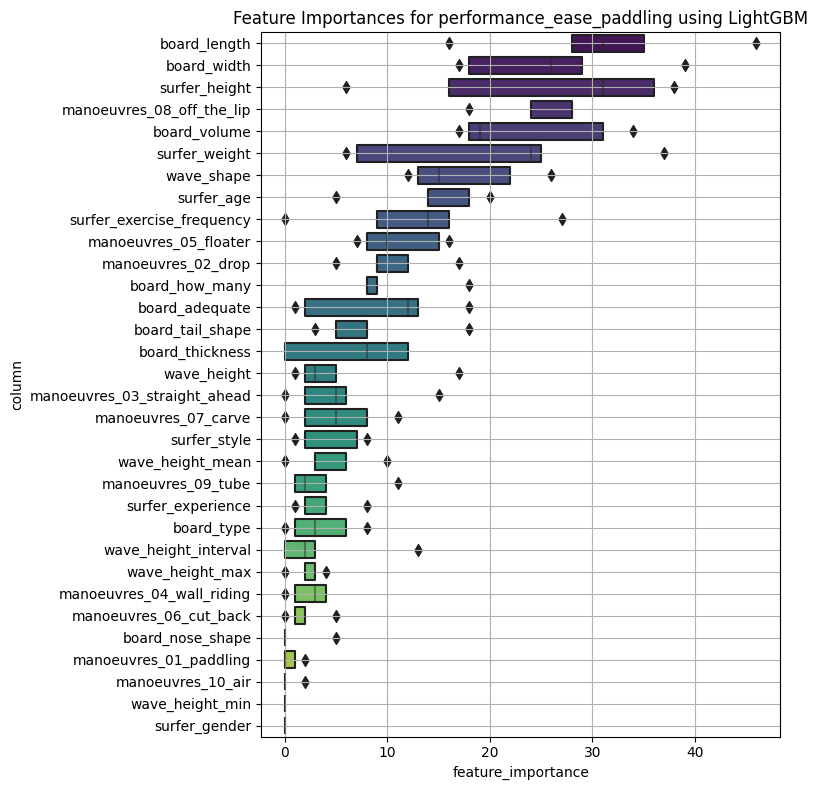

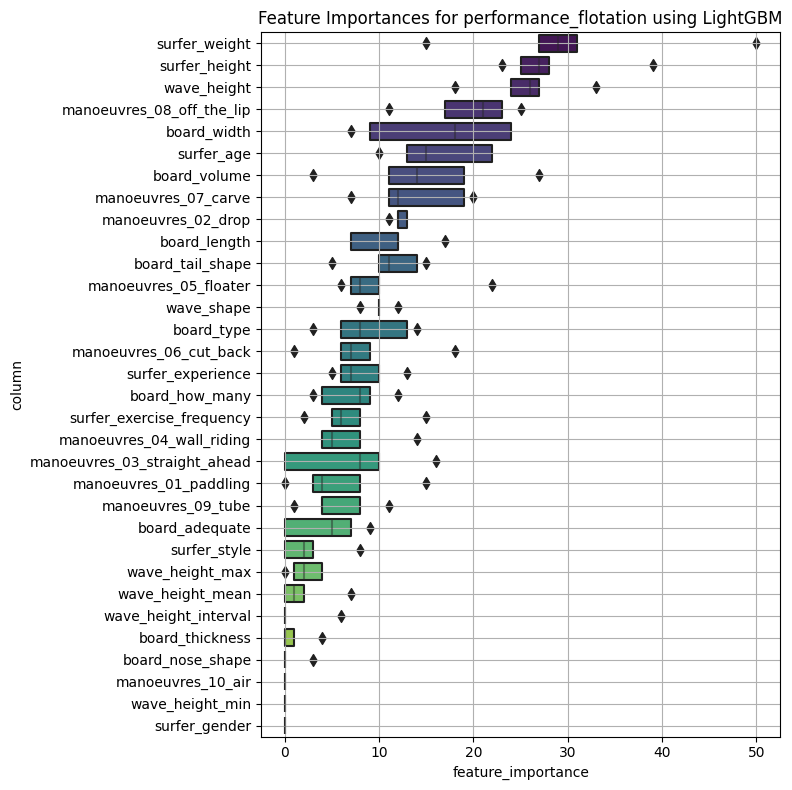

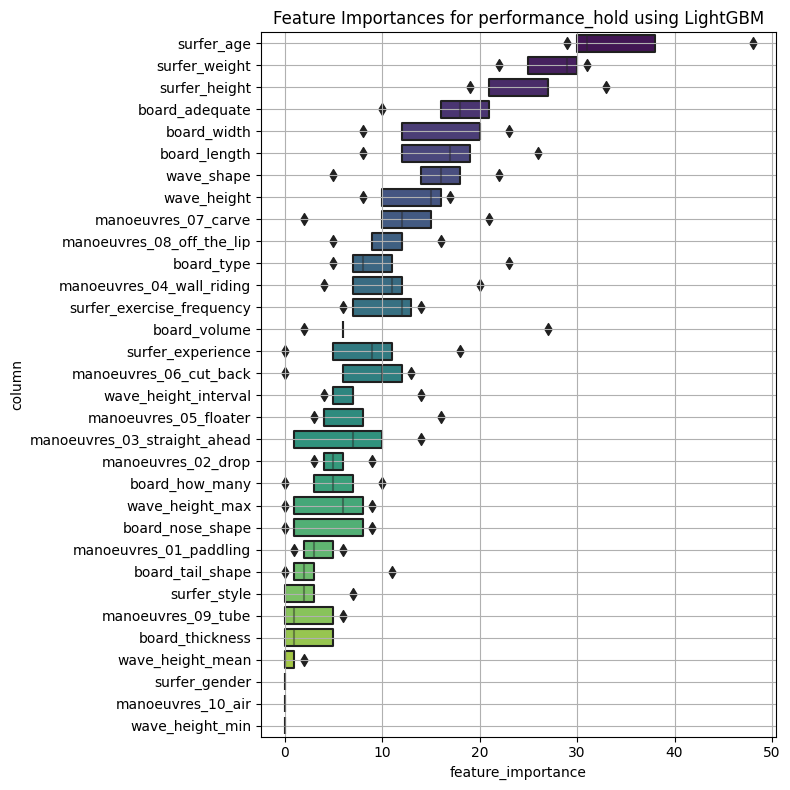

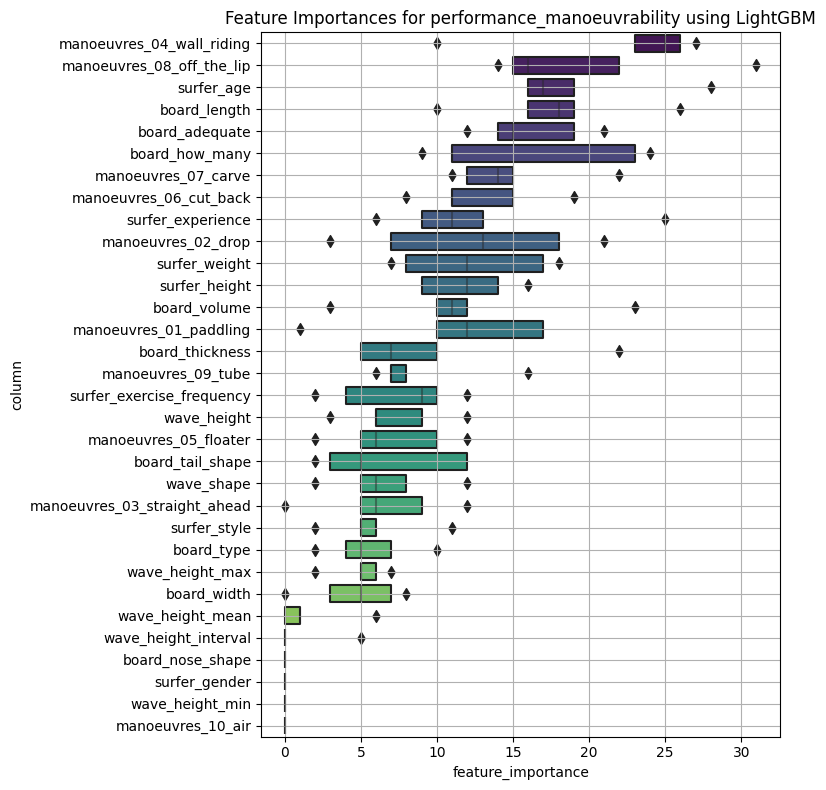

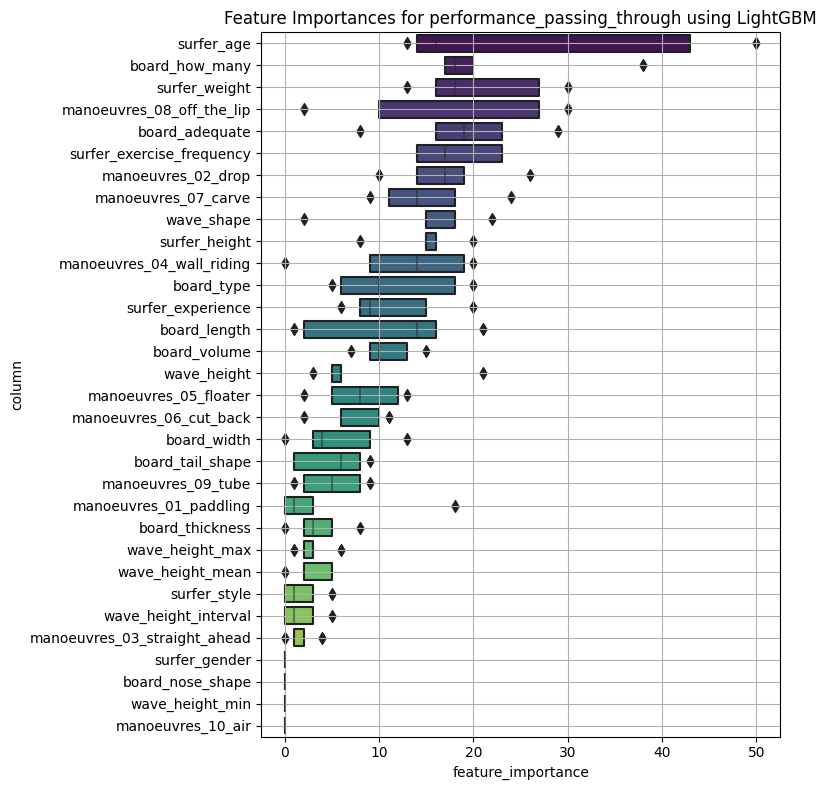

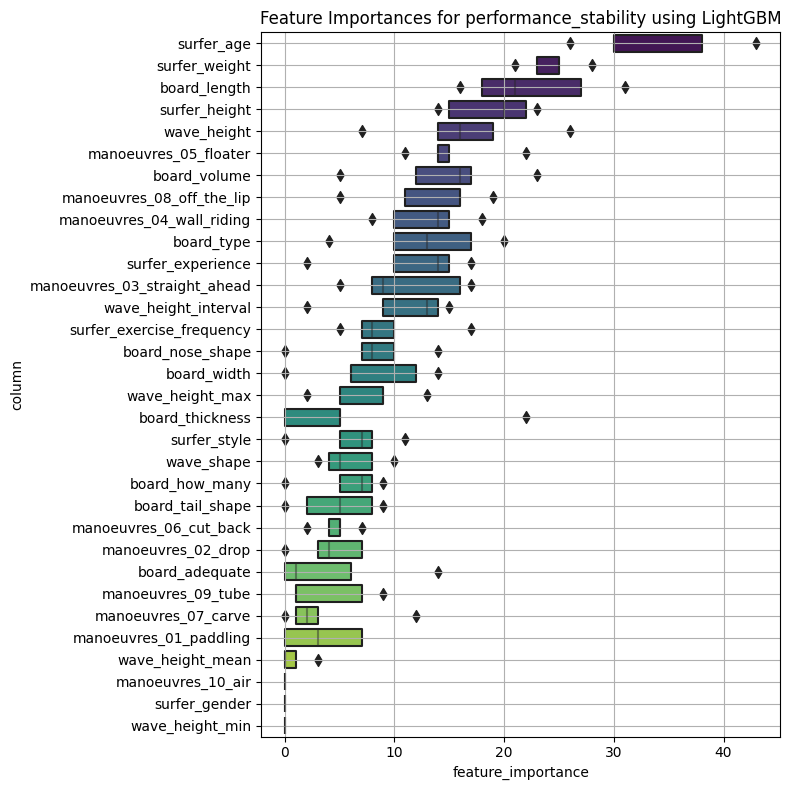

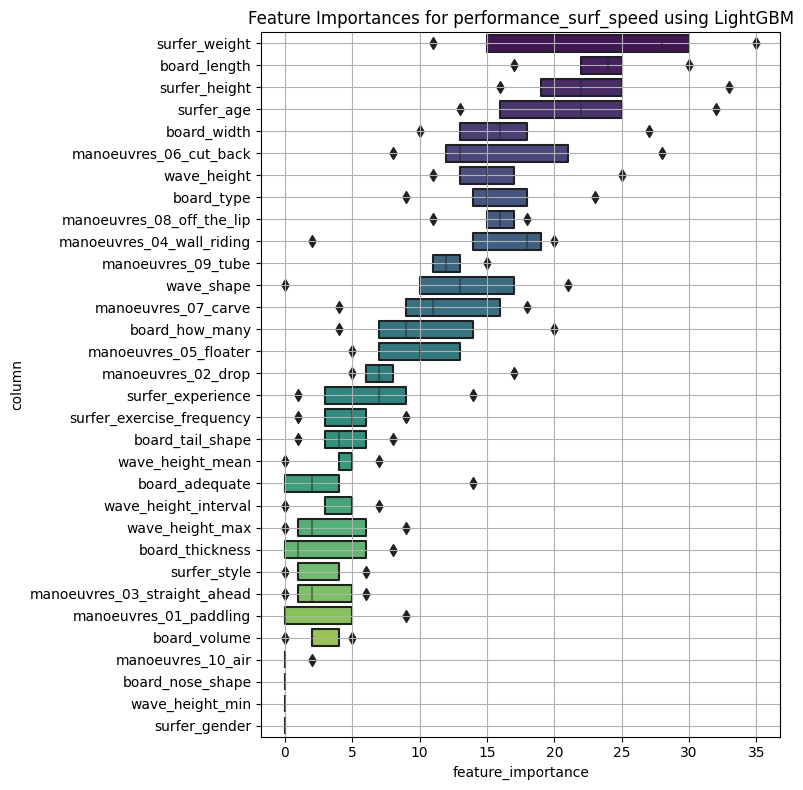

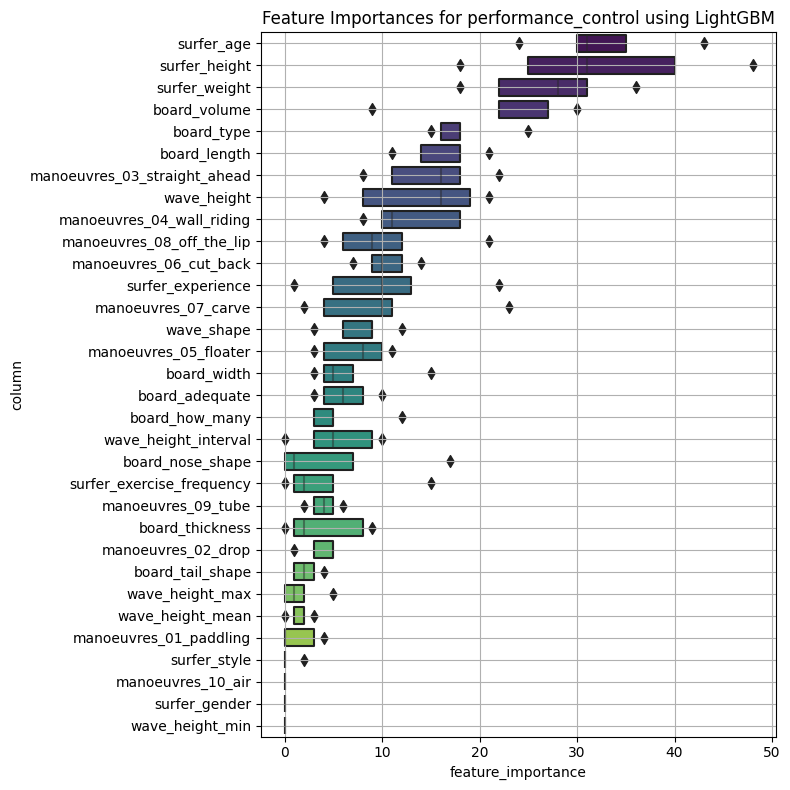

In [16]:
params = {
    'n_estimators': 100,
    'random_state': 42,
    'verbose': -1
}

for target_column in targets:
    plot_feature_importance(lgb.LGBMRegressor, params, X_train, y_train[target_column], target_column, model_name='LightGBM')


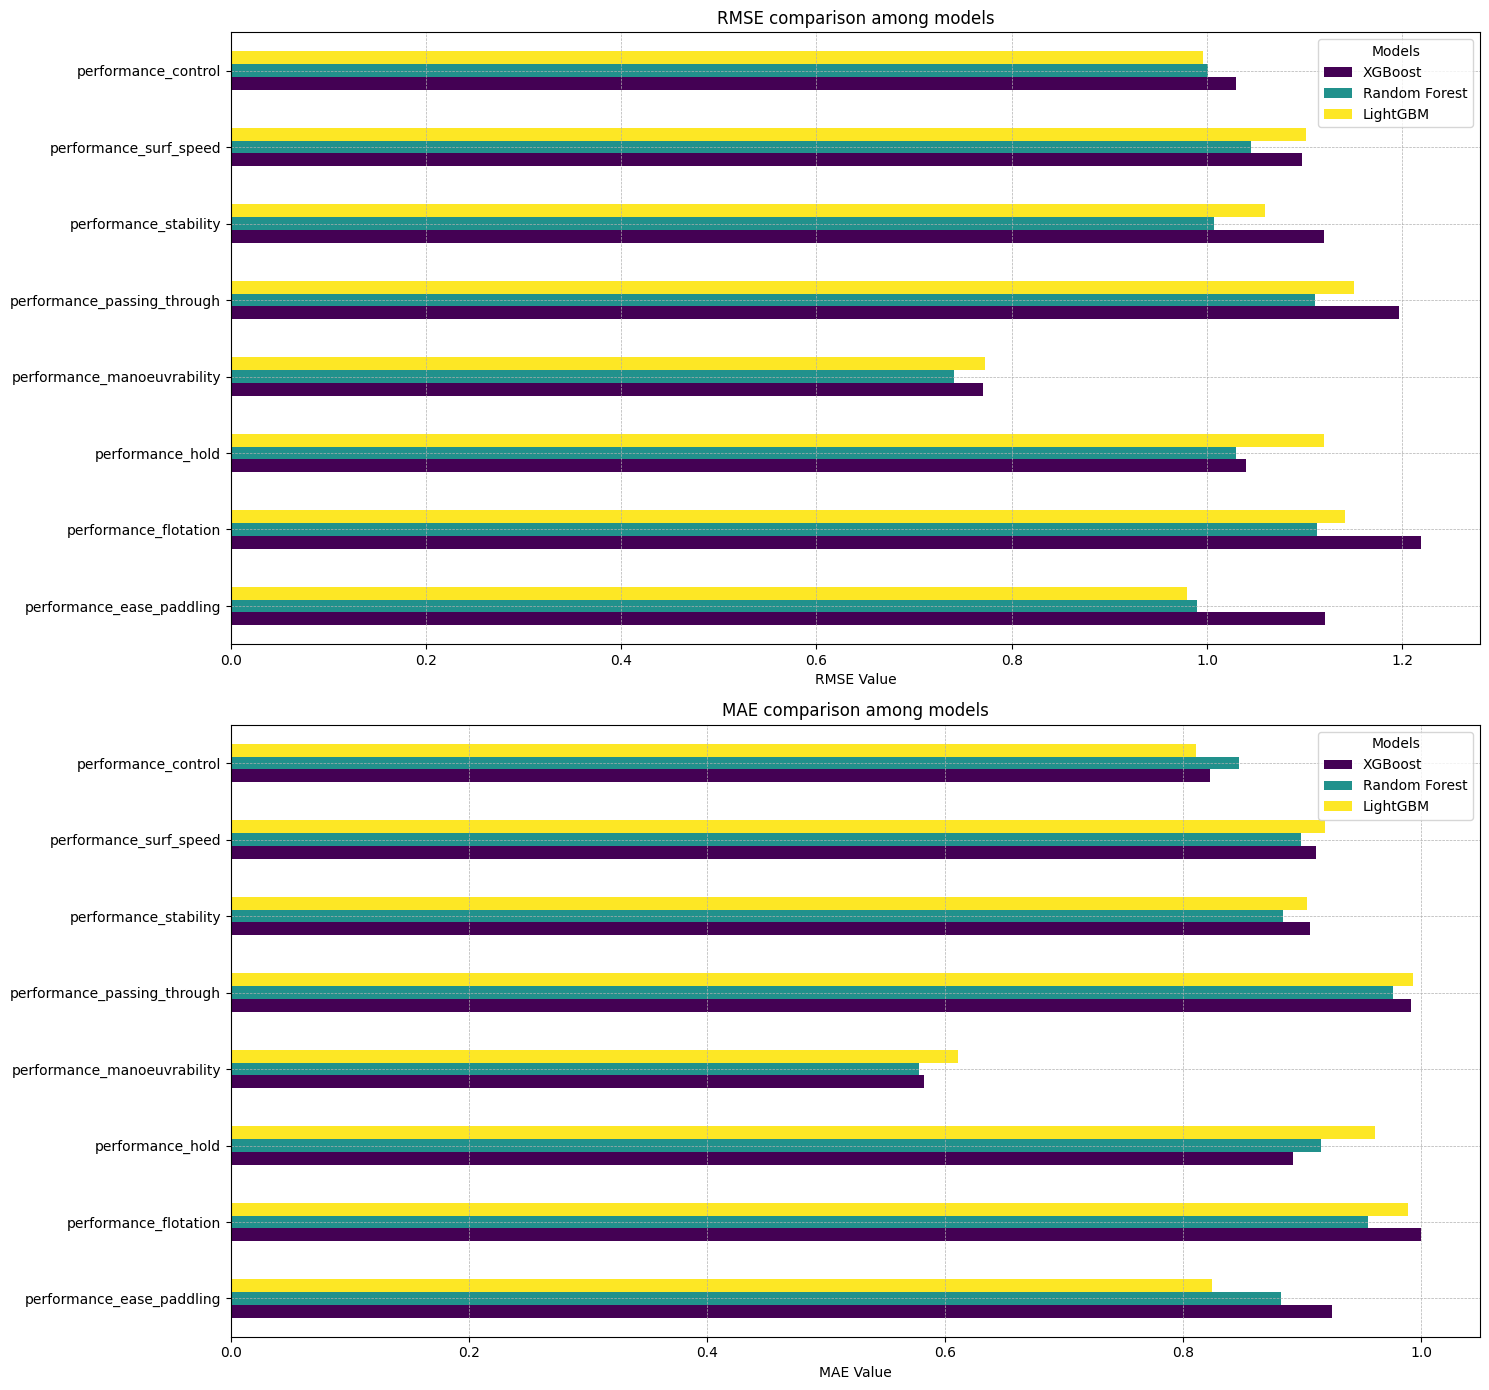

In [17]:
# Given data
results = {
    "XGBoost": {
        "performance_ease_paddling": {"RMSE": 1.1213, "MAE": 0.9245},
        "performance_flotation": {"RMSE": 1.2187, "MAE": 0.9992},
        "performance_hold": {"RMSE": 1.0404, "MAE": 0.8924},
        "performance_manoeuvrability": {"RMSE": 0.7701, "MAE": 0.5819},
        "performance_passing_through": {"RMSE": 1.1968, "MAE": 0.9916},
        "performance_stability": {"RMSE": 1.1196, "MAE": 0.9066},
        "performance_surf_speed": {"RMSE": 1.0975, "MAE": 0.9118},
        "performance_control": {"RMSE": 1.0297, "MAE": 0.8222}
    },
    "Random Forest": {
        "performance_ease_paddling": {"RMSE": 0.9893, "MAE": 0.8817},
        "performance_flotation": {"RMSE": 1.1131, "MAE": 0.9549},
        "performance_hold": {"RMSE": 1.0298, "MAE": 0.9158},
        "performance_manoeuvrability": {"RMSE": 0.7408, "MAE": 0.5778},
        "performance_passing_through": {"RMSE": 1.1111, "MAE": 0.9763},
        "performance_stability": {"RMSE": 1.0072, "MAE": 0.8835},
        "performance_surf_speed": {"RMSE": 1.0454, "MAE": 0.8986},
        "performance_control": {"RMSE": 1.0010, "MAE": 0.8465}
    },
    "LightGBM": {
        "performance_ease_paddling": {"RMSE": 0.9800, "MAE": 0.8240},
        "performance_flotation": {"RMSE": 1.1417, "MAE": 0.9886},
        "performance_hold": {"RMSE": 1.1196, "MAE": 0.9613},
        "performance_manoeuvrability": {"RMSE": 0.7727, "MAE": 0.6106},
        "performance_passing_through": {"RMSE": 1.1503, "MAE": 0.9929},
        "performance_stability": {"RMSE": 1.0597, "MAE": 0.9040},
        "performance_surf_speed": {"RMSE": 1.1010, "MAE": 0.9194},
        "performance_control": {"RMSE": 0.9957, "MAE": 0.8105}
    }
}

# Convert the nested dictionary to DataFrame
df_results_rmse = pd.DataFrame({model: {target: values["RMSE"] for target, values in model_results.items()} for model, model_results in results.items()})
df_results_mae = pd.DataFrame({model: {target: values["MAE"] for target, values in model_results.items()} for model, model_results in results.items()})

# Plotting the results
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 14))

df_results_rmse.plot(kind='barh', ax=axes[0], title="RMSE comparison among models", colormap='viridis')
df_results_mae.plot(kind='barh', ax=axes[1], title="MAE comparison among models", colormap='viridis')

axes[0].set_xlabel('RMSE Value')
axes[1].set_xlabel('MAE Value')
axes[0].legend(title="Models")
axes[1].legend(title="Models")

# Add grid to the plots
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

fig.tight_layout()
plt.show()




In [18]:
# Calculate the average RMSE and MAE for each model
average_rmse = df_results_rmse.mean(axis=0)
average_mae = df_results_mae.mean(axis=0)

# Find the model with the lowest average RMSE and MAE
best_model_rmse = average_rmse.idxmin()
best_model_mae = average_mae.idxmin()

print(f"Model with the lowest average RMSE: {best_model_rmse} (RMSE: {average_rmse[best_model_rmse]:.4f})")
print(f"Model with the lowest average MAE: {best_model_mae} (MAE: {average_mae[best_model_mae]:.4f})")


Model with the lowest average RMSE: Random Forest (RMSE: 1.0047)
Model with the lowest average MAE: Random Forest (MAE: 0.8669)


In [19]:
# 1. Dla każdego celu, wyznacz ważność cech
feature_importances_list = []

for target_column in targets:
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train[target_column])
    feature_importances_list.append(rf.feature_importances_)

# 2. Uzyskaj średnią ważność cech dla wszystkich celów
average_importance = np.mean(np.array(feature_importances_list), axis=0)
features_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': average_importance
})

# 3. Usuń te cechy, które mają ważność poniżej pewnego ustalonego progu
threshold = features_df['importance'].mean()  # używamy średniej ważności jako progu
selected_features = features_df[features_df['importance'] > threshold]['feature'].tolist()

print(f"Selected features based on importance: {selected_features}")


Selected features based on importance: ['board_adequate', 'board_how_many', 'board_length', 'board_volume', 'board_width', 'manoeuvres_08_off_the_lip', 'surfer_age', 'surfer_height', 'surfer_weight', 'wave_height']


In [20]:
from sklearn.feature_selection import RFE

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Initialize RFE
rfe = RFE(estimator=model, n_features_to_select=15)  # Selecting top 15 features, you can adjust this number

# Fit RFE
rfe = rfe.fit(X_train, y_train['performance_ease_paddling'])  # We can select one target to start, or average results for all

# Get the features ranking
ranking_df = pd.DataFrame({'Feature': X_train.columns, 'Ranking': rfe.ranking_})

# Selected features are ranked as 1
selected_features = ranking_df[ranking_df['Ranking'] == 1]['Feature'].tolist()

print(f"Selected features based on RFE: {selected_features}")


Selected features based on RFE: ['board_how_many', 'board_length', 'board_tail_shape', 'board_thickness', 'board_volume', 'board_width', 'manoeuvres_05_floater', 'manoeuvres_08_off_the_lip', 'surfer_age', 'surfer_height', 'surfer_style', 'surfer_weight', 'wave_height', 'wave_shape', 'wave_height_mean']
